<a href="https://colab.research.google.com/github/draperkm/DCGAN_Implementation/blob/main/DCGAN_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DCGAN Implementation - Faces data set

In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

Mounted at /content/drive
Note: using Google CoLab
Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


# Imports

In [2]:
from __future__ import print_function
%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

# Set random seem for reproducibility
#manualSeed = 999
manualSeed = random.randint(1, 10000) # use if you want new results

print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  6193


# Set hyperparameters

In [3]:
# Root directory for dataset
dataroot = "/content/drive/MyDrive/GitHub_Databases/Faces_ARCH1"

# Number of workers for dataloader
workers = 2 

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this size
image_size = 64

# Number of channels in the training images. For color images it is 3
nc = 3

# Size of z latent vector (generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 10

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Create data to be loaded

In [4]:
# Create the dataset of ImageFolder class
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

# dset.ImageFolder: it creates a list of directory names: A generic data loader where the images are arranged in this way by default:
# root/dog/xxx.png
# root/dog/xxy.png
# root/dog/[...]/xxz.png
# root/cat/123.png
# root/cat/nsdf3.png
# root/cat/[...]/asd932_.png

# ImageFolder need a dataroot with a folder upper than the one where we contain the images
# transforms: transform the images in the folder

# Plot the dataset

<function matplotlib.pyplot.show(*args, **kw)>

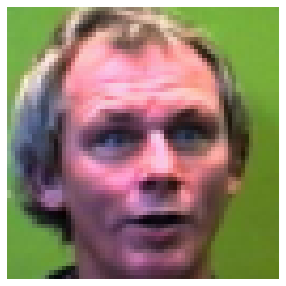

In [6]:
# Create the dataloader
single_image = torch.utils.data.DataLoader(dataset, batch_size=1,
                                         shuffle=True, num_workers=workers)

# torch.utils.data.DataLoader https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
# Data loader. Combines a dataset and a sampler, and provides an iterable over the given dataset.
# Data loader read the path "root/cat/[...]/asd932_.png" and stores the data in an array (tensor)

image, labels = next(iter(single_image))

# For imshow, if the image is 3 channel / RGB
# the colours of the image wouldn't look as suppposed if 
# we do not use "normalize=True" in "vutils.make_grid()"

plt.figure(figsize=(5,5))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(image[0].to(device), padding=2, normalize=True).cpu(),(1,2,0)))
plt.show

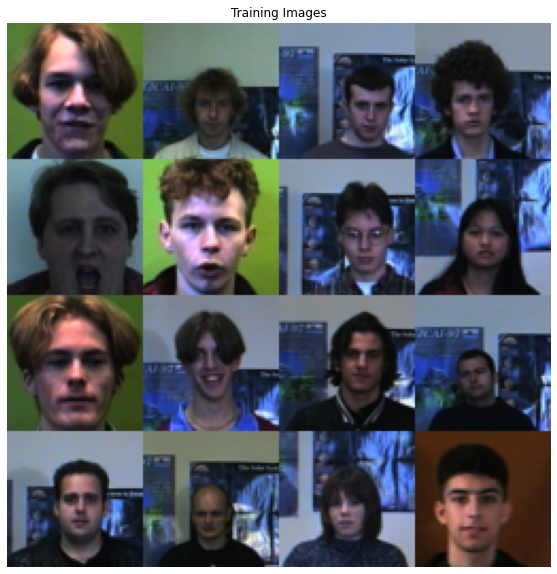

In [7]:
# Create the dataloader
dataloader2 = torch.utils.data.DataLoader(dataset, batch_size=16,
                                         shuffle=True, num_workers=workers)

# Plot some training images
real_batch = next(iter(dataloader2))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Training Images")

plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:16], padding=0, normalize=True, nrow = 4).cpu(),(1,2,0)))

# We can modify how many images to show per row with "nrow"

# Initialise weights

In [8]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# More on how to initialise weights and bias in PyTorch:
# https://androidkt.com/initialize-weight-bias-pytorch/#:~:text=The%20aim%20of%20weight%20initialization,will%20take%20longer%20to%20converge.

# Create Generator

In [9]:
# Create Generator class

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [10]:
# Create the generator network
netG = Generator(ngpu).to(device)

# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.2
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


# Create Discriminator

In [11]:
# Create Discriminator class

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [12]:
# Create the Discriminator network
netD = Discriminator(ngpu).to(device)
    
# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.2
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [13]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
# the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# nz = size of z latent vector (i.e. size of generator input)
# nz = 100
# torch.randn: Returns a tensor filled with random numbers from a normal distribution with mean 0 and variance 1.
# The shape of the tensor is defined by the variable argument size.
# size (int...) – a sequence of integers defining the shape of the output tensor.

# Establish convention for real and fake labels during training
real_label = float(1)
fake_label = float(0)


# Setup Adam optimizers for both G and D
# optim.Adam(): Implements the Adam algorithm.
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))


# Training

In [14]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

print("Starting Training Loop...")

# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        # This second loop iterates over each batch, data is the "unpacked" batch, i is the index of the iteration

        # The enumerate() method adds a counter to an iterable and returns it (the enumerate object).
        # enumerate(iterable, start=0)
        # https://www.programiz.com/python-programming/methods/built-in/enumerate
        # for i, data in enumerate(trainloader, 0): restarts the trainloader iterator on each epoch. That is how python iterators work.
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################

        ## Train with all-real batch ###########################################
        netD.zero_grad()
        # In PyTorch, for every mini-batch during the training phase, we typically want to explicitly set the gradients to zero 
        # before starting to do backpropragation (i.e., updating the Weights and biases) because PyTorch accumulates 
        # the gradients on subsequent backward passes. This accumulating behaviour is convenient while training RNNs or when we want 
        # to compute the gradient of the loss summed over multiple mini-batches. So, the default action has been set to accumulate 
        # (i.e. sum) the gradients on every loss.backward() call.
        # https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch


        # Format batch
        real_cpu = data[0].to(device)
        # .to (device) Function Can Be Used To Specify CPU or GPU.

        b_size = real_cpu.size(0)
        # In Python, numpy.size() function count the number of elements along a given axis, in this case along the 0 axis

        label = torch.full((b_size,), real_label, device=device)
        # torch.full(size, fill_value, *, out=None, dtype=None, layout=torch.strided, device=None, requires_grad=False) → Tensor
        # Creates a tensor of size "size" filled with "fill_value"
        # https://pytorch.org/docs/stable/generated/torch.full.html

        # Forward pass a batch of real images through the Discriminator D and flatten the output
        output = netD(real_cpu).view(-1)
        # The view(-1) operation flattens the tensor, if it wasn’t already flattened
        # https://discuss.pytorch.org/t/what-does-view-1-do/109803

        # Calculate Discriminator's loss on all-real batch
        errD_real = criterion(output, label)

        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch ###########################################

        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)

        # Generate fake image batch with G
        fake = netG(noise)

        label.fill_(fake_label)
        # Fills self tensor with the specified value.
        # https://pytorch.org/docs/stable/generated/torch.Tensor.fill_.html


        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Returns a new Tensor, detached from the current graph.

        # Calculate Distriminator's loss on the all-fake batch
        errD_fake = criterion(output, label)

        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake

        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        # In PyTorch, for every mini-batch during the training phase, we typically want to explicitly set the gradients to zero

        label.fill_(real_label)  # fake labels are real for generator cost

        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)

        # Calculate Generator's loss based on this output
        errG = criterion(output, label)

        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()

        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving Generators's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1

Starting Training Loop...
[0/10][0/87]	Loss_D: 1.7159	Loss_G: 5.6400	D(x): 0.4737	D(G(z)): 0.5023 / 0.0057
[0/10][50/87]	Loss_D: 1.8245	Loss_G: 26.6558	D(x): 0.9441	D(G(z)): 0.7726 / 0.0000
[1/10][0/87]	Loss_D: 0.9928	Loss_G: 19.7062	D(x): 0.9906	D(G(z)): 0.5299 / 0.0000
[1/10][50/87]	Loss_D: 0.3583	Loss_G: 11.7883	D(x): 0.8532	D(G(z)): 0.0001 / 0.0003
[2/10][0/87]	Loss_D: 0.2421	Loss_G: 9.9219	D(x): 0.9747	D(G(z)): 0.1747 / 0.0001
[2/10][50/87]	Loss_D: 0.1742	Loss_G: 6.8822	D(x): 0.9327	D(G(z)): 0.0512 / 0.0021
[3/10][0/87]	Loss_D: 0.2167	Loss_G: 6.6260	D(x): 0.9162	D(G(z)): 0.0959 / 0.0082
[3/10][50/87]	Loss_D: 0.3130	Loss_G: 6.4211	D(x): 0.9747	D(G(z)): 0.2256 / 0.0037
[4/10][0/87]	Loss_D: 0.3090	Loss_G: 5.3827	D(x): 0.8932	D(G(z)): 0.1374 / 0.0119
[4/10][50/87]	Loss_D: 0.2882	Loss_G: 4.4724	D(x): 0.9312	D(G(z)): 0.1702 / 0.0240
[5/10][0/87]	Loss_D: 0.2777	Loss_G: 4.2714	D(x): 0.8191	D(G(z)): 0.0214 / 0.0275
[5/10][50/87]	Loss_D: 0.2660	Loss_G: 3.5824	D(x): 0.9176	D(G(z)): 0.1286 / 

# Loss during training

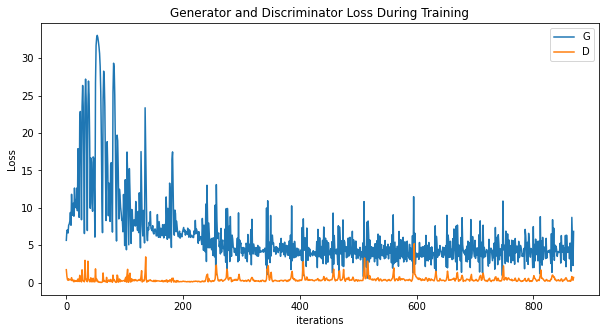

In [15]:
# Plot the losses
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Making prediction

<function matplotlib.pyplot.show(*args, **kw)>

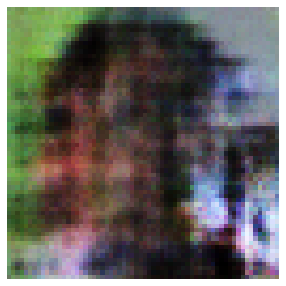

In [27]:
rand_tensor = torch.randn(1, 100, 1, 1, device=device)

tensor_image = netG(rand_tensor)

plt.figure(figsize=(5,5))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(tensor_image.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

plt.show

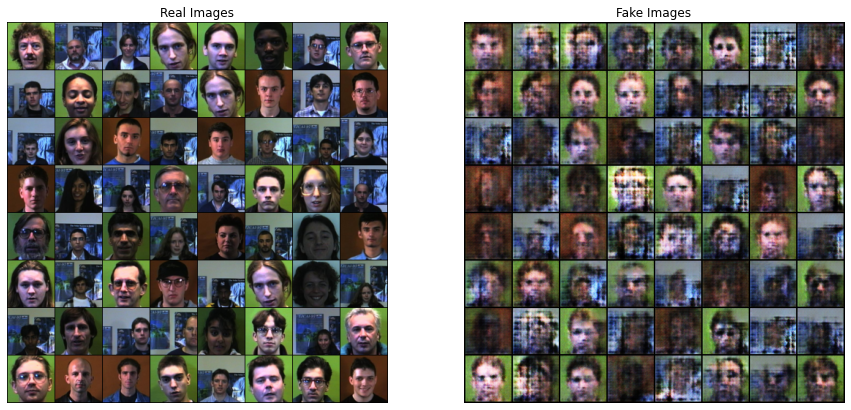

In [22]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=1, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()